Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [1]:
# !pip install git+https://github.com/philferriere/cocoapi.git

In [2]:
%matplotlib inline
import os
import skimage.io as io
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [3]:
COCO_ROOT = r'D:\train\coco\data'

In [4]:
from pycocotools.coco import COCO

In [5]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
# тестирование работы GPU
def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print("GPU работает:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

 CPU работает:
100 циклов: 366.33ms
GPU работает:
100 циклов: 356.61ms
 CPU работает:
100 циклов: 344.31ms
GPU работает:
100 циклов: 6.01ms


In [7]:

def test_img(patch,model):
    test_img = plt.imread(patch)
    test_img = test_img/255
    print('Оригинал')
    plt.imshow(test_img)
    plt.show()
    image = tf.image.resize(test_img, (256,256))
    print('Подготовлденное')
    plt.imshow(image)
    plt.show()
    print('предсказания')
    pred = model(image[None, ...], training=False).numpy()[0]
    pred[pred>=0.35]=1
    pred[pred!=1]=0
    plt.imshow(pred)
    plt.show() 
    c = image.numpy() + pred
    c[c>1]=1
    plt.imshow(c)
    plt.show()

## Универсальный класс Dataset для сегментации

In [8]:
class Dataset_seg():
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    
    def __init__(srlf,img_list):
        self.img_list = img_list

    def crop_images(self, img,inp_size,random_crop):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def read_images(self,item_patch):
        return plt.imread(item_patch)
    
    
    def train_dataset(self, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined,inp_size,random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)

        return dataset

    def val_dataset(self, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)

        return dataset

In [9]:
class COCO_Dataset(Dataset_seg):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

        
    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = plt.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [10]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=14.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [11]:
x_train = COCO_dataset_train.train_dataset(256)

In [12]:
x_test = COCO_dataset_val.train_dataset(256)

In [13]:
z = [i for i in iter(x_train.take(5))]

In [14]:
a = z[1][0].numpy()

In [15]:
b= z[1][1].numpy()

In [16]:
a.shape,a.max(),a.min()

((256, 256, 3), 1.0, 0.0)

In [17]:
b.shape,b.max(),b.min()

((256, 256, 1), 1.0, 0.0)

In [18]:
(a+b).shape,(a+b).max(),(a+b).min()

((256, 256, 3), 2.0, 0.0)

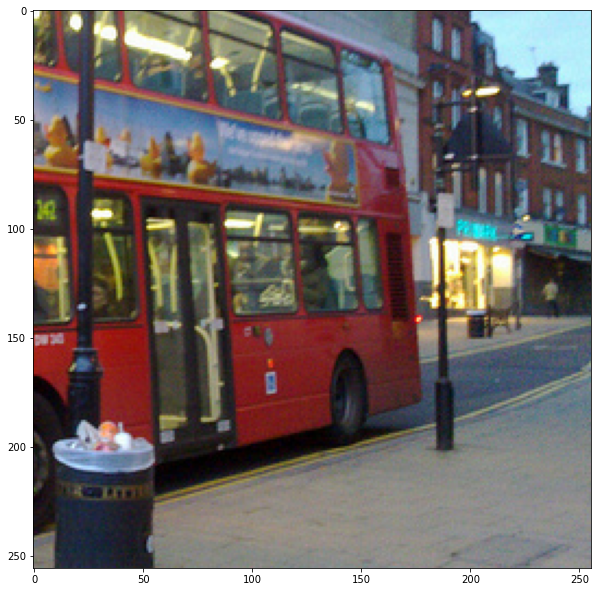

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(10, 15))
plt.imshow(a)
plt.show()

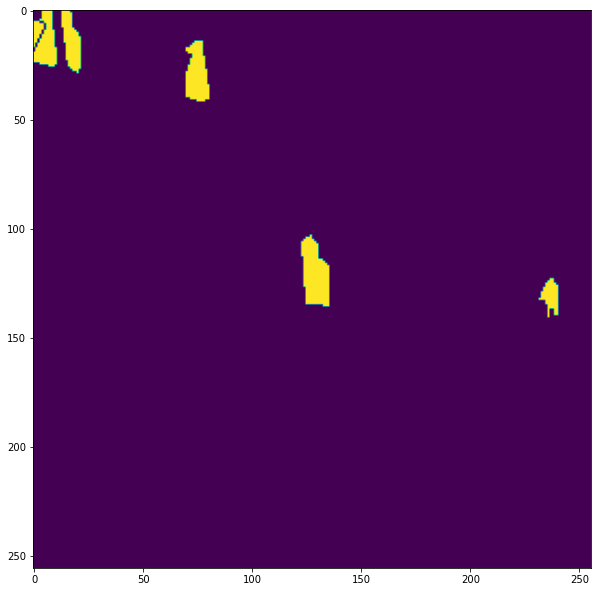

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(10, 15))
plt.imshow(b)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


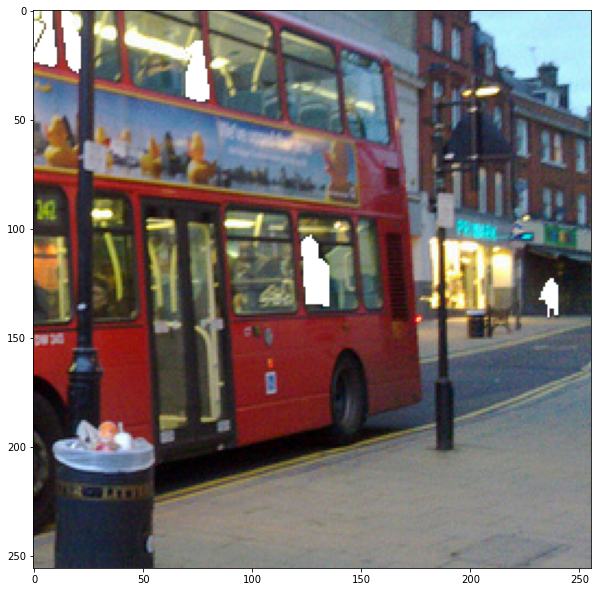

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(10, 15))
plt.imshow(a+b)
plt.show()

In [24]:
len(x_train),len(x_test)

(64115, 2693)

In [25]:
z = [i for i in iter(x_test.take(5))]

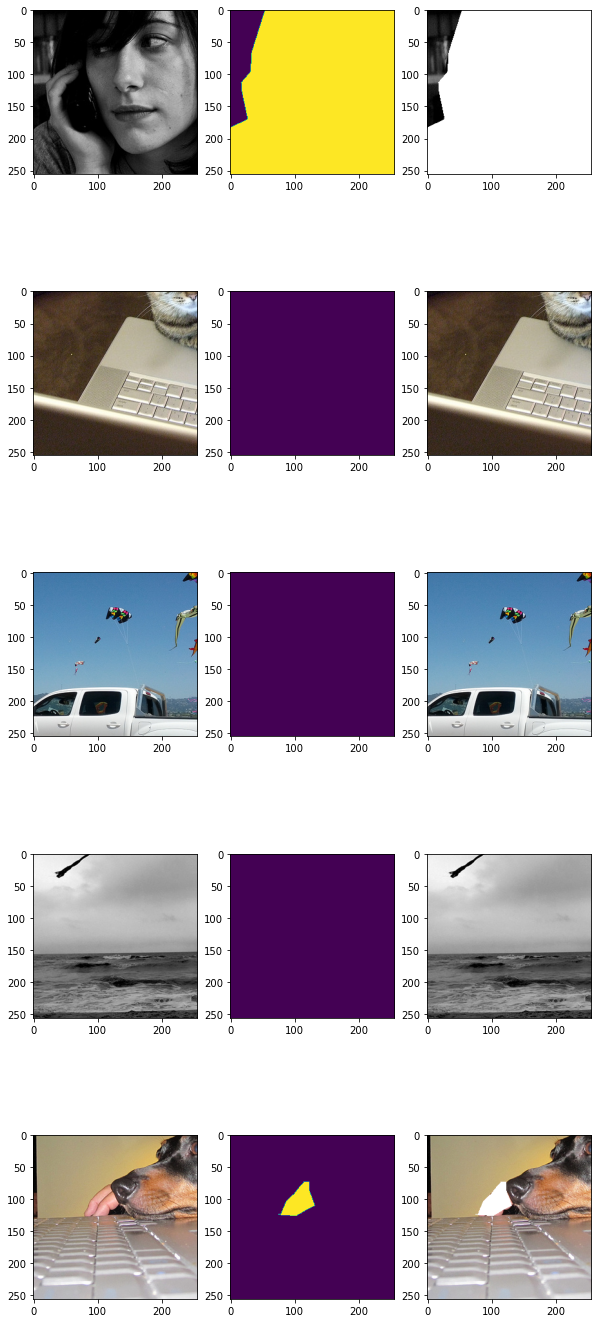

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(10, 25))
k=0
for i in range(1,16,3):

    ax = fig.add_subplot(5, 3, i)
    ax.imshow(z[k][0])
    ax = fig.add_subplot(5, 3, i+1)
    ax.imshow(z[k][1])
    c = z[k][0].numpy()+z[k][1].numpy()
    c[c>1]=1
    ax = fig.add_subplot(5, 3, i+2)
    ax.imshow(c)
    k+=1
plt.show()

## Модель ASPP

In [41]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)
        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):
#         x_in = self.inp(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

In [42]:

model = ASPPNet()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.build(input_shape=(None,256,256,3))
model.summary()

Model: "aspp_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           multiple                  1792      
_________________________________________________________________
conv2d_56 (Conv2D)           multiple                  36928     
_________________________________________________________________
conv2d_57 (Conv2D)           multiple                  73856     
_________________________________________________________________
conv2d_58 (Conv2D)           multiple                  147584    
_________________________________________________________________
conv2d_59 (Conv2D)           multiple                  295168    
_________________________________________________________________
conv2d_60 (Conv2D)           multiple                  590080    
_________________________________________________________________
conv2d_61 (Conv2D)           multiple                  1

In [29]:
batch_size= 10
x_train = x_train.batch(batch_size)
x_test = x_test.batch(batch_size)

In [55]:
%%time
model.fit(x_train, epochs=3,validation_data=x_test)

Epoch 1/3
6412/6412 [==============================] - 1853s 289ms/step - loss: 0.2672 - accuracy: 0.8822 - val_loss: 0.2568 - val_accuracy: 0.8856
Epoch 2/3
6412/6412 [==============================] - 1852s 289ms/step - loss: 0.2600 - accuracy: 0.8870 - val_loss: 0.2460 - val_accuracy: 0.8940
Epoch 3/3
6412/6412 [==============================] - 1853s 289ms/step - loss: 0.2480 - accuracy: 0.8927 - val_loss: 0.2391 - val_accuracy: 0.8995
Wall time: 1h 32min 37s


Оригинал


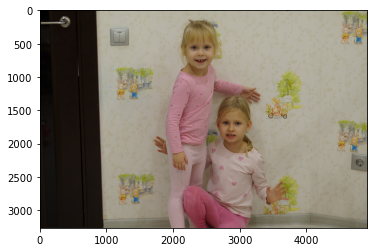

Подготовлденное


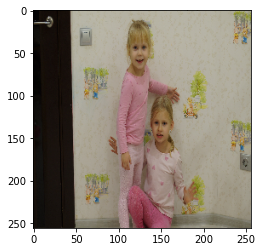

предсказания


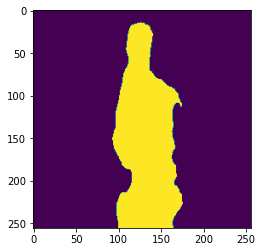

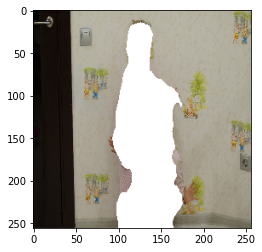

In [56]:
%matplotlib inline
test_img('1.jpg',model)

Оригинал


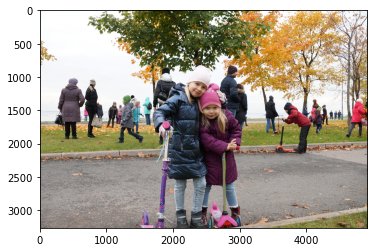

Подготовлденное


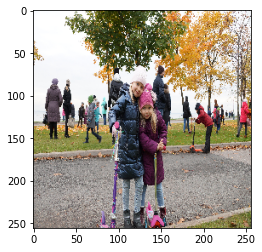

предсказания


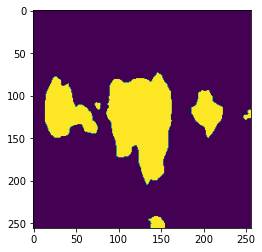

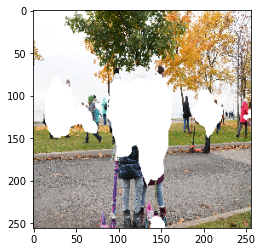

In [57]:
%matplotlib inline
test_img('2.jpg',model)

In [47]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1) #128*128*64

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2) #64*64*128

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3) #32*32*256

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4) #16*16*512

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    
    
    
    
    

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3) #32*32*(256 + 256)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out) #64*64*256
    out = tf.concat([out3, out], axis=3)#64*64*(256 + 256)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)#128*128*128
    out = tf.concat([out2, out], axis=3) #64*64*(128+128)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out) #256*256*64
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out) #256*256*1

    return tf.keras.Model(inputs=x, outputs=out)


In [48]:
model_2 = build_model()
model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_74[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_75[0][0]                  
____________________________________________________________________________________________

In [52]:
%%time
model_2.fit(x_train, epochs=2,validation_data=x_test)

Epoch 1/2
6412/6412 [==============================] - 4368s 681ms/step - loss: 0.3309 - accuracy: 0.8471 - val_loss: 0.3060 - val_accuracy: 0.8578
Epoch 2/2
6412/6412 [==============================] - 4369s 681ms/step - loss: 0.2989 - accuracy: 0.8654 - val_loss: 0.2928 - val_accuracy: 0.8699
Wall time: 2h 25min 37s


Оригинал


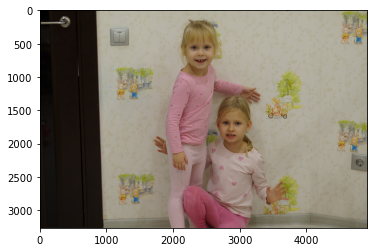

Подготовлденное


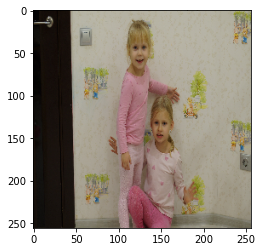

предсказания


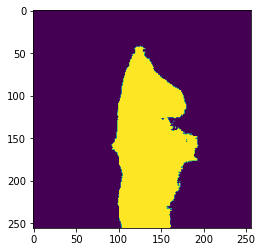

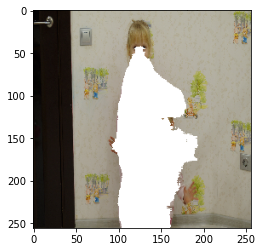

In [53]:
%matplotlib inline
test_img('1.jpg',model_2)

Оригинал


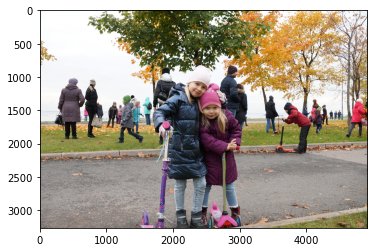

Подготовлденное


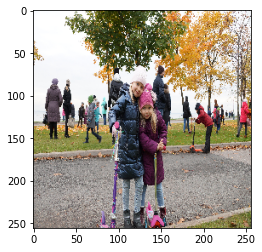

предсказания


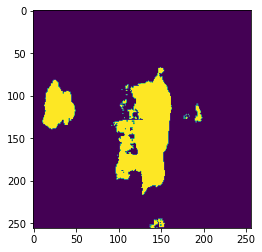

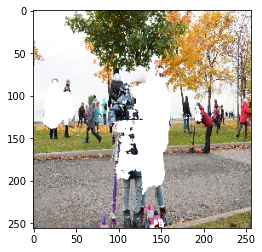

In [54]:
%matplotlib inline
test_img('2.jpg',model_2)